In [103]:
# --- Standard Library ---
import os                        # File and directory operations
import glob                      # Pattern matching for file paths
from pathlib import Path         # Object-oriented filesystem paths
from collections import defaultdict  # Simplified dict with default values

# --- Data Handling & Structures ---
import yaml                      # YAML file loading
import numpy as np               # Numerical arrays and math
import pandas as pd              # DataFrames and data analysis

# --- Plotting ---
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns            # Statistical plots built on top of matplotlib
import plotly.express as px              # High-level plotting API
import plotly.graph_objects as go        # Low-level figure components
from plotly.subplots import make_subplots  # Subplot layout management

# --- OpenAI API ---
from openai import OpenAI        # LLM-based concept scoring (custom client assumed)

# --- Jupyter Notebook Utilities ---
from IPython.display import display, update_display  # Dynamic output updates
from tqdm.notebook import tqdm   # Interactive progress bars in notebooks


In [2]:
# Configuration
BASE_PATH = "../../../dropover-at/"
CONCEPTS_FILE_PATH=os.path.join(BASE_PATH, "concepts.yaml")
PROJECT_NAME = BASE_PATH.split(os.sep)[-2]
MODEL="google/gemini-2.5-pro"

# Initialize OpenAI client for use with OpenRouter
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY")
)

## Load Concepts from YAML

In [3]:
concepts_data = {}

with open(CONCEPTS_FILE_PATH, 'r') as file:
    concepts_data =  yaml.safe_load(file)

print("Loaded")
for concept_type in concepts_data.keys():
    print(f"- {len(concepts_data.get(concept_type, []))} {concept_type.replace("_", " ")}s")
print(f"for project {PROJECT_NAME}")

Loaded
- 11 technical conceptss
- 7 business conceptss
for project dropover-at


## Get all Java prod source code files

In [4]:
# this is a Maven project, so prod files are in a specific directory
all_java_files = glob.glob(BASE_PATH + "**/src/main/java/**/*.java", recursive=True)
# remove the info files for packages
all_java_files = [file for file in all_java_files if not "package-info.java" in file]
print(f"Total Java files: {len(all_java_files)}")

Total Java files: 214


## Concept File Discovery
Get all files that match any concept pattern.

In [5]:
matched_files_dict = {}

for concept_type in concepts_data.keys():
    matched_files_dict[concept_type] = {}
    concepts = concepts_data.get(concept_type, [])

    for concept in concepts:
        concept_name = concept.get('name')
        files = []

        for pattern in concept.get('file_globs', []):
            matching_files = glob.glob(os.path.join(BASE_PATH, pattern), recursive=True)
            files.extend(matching_files)

        matched_files_dict[concept_type][concept_name] = list(set(files))  # remove duplicates

# Print statistics
print("\n📊 Matched Files Statistics:")
total_concepts = 0
total_files = set()

for concept_type, concepts in matched_files_dict.items():
    print(f"\n{concept_type}:")
    print(f"  Concepts: {len(concepts)}")
    concept_file_counts = [len(files) for files in concepts.values()]
    for concept_name, files in concepts.items():
        print(f"    {concept_name}: {len(files)} file(s)")
        total_files.update(files)
    total_concepts += len(concepts)

print(f"\nTotal concept types: {len(matched_files_dict)}")
print(f"Total concepts: {total_concepts}")
print(f"Total unique matched files: {len(total_files)}")


📊 Matched Files Statistics:

technical_concepts:
  Concepts: 11
    Boundary: 67 file(s)
    Interactor: 65 file(s)
    Entity: 12 file(s)
    Gateway: 17 file(s)
    Delivery: 51 file(s)
    RESTful API: 15 file(s)
    Dependency Injection: 3 file(s)
    Request Model: 30 file(s)
    Response Model: 22 file(s)
    POJO Entities: 10 file(s)
    Validation: 13 file(s)

business_concepts:
  Concepts: 7
    Site: 36 file(s)
    Comment: 41 file(s)
    Creator: 14 file(s)
    File: 34 file(s)
    Scheduling: 67 file(s)
    Todo List: 63 file(s)
    Mail Notification: 16 file(s)

Total concept types: 2
Total concepts: 18
Total unique matched files: 301


Flatten all matched files for unmatching calculatiun

Get all files that don't match any concept pattern.

In [6]:
matched_files = set()
for type_dict in matched_files_dict.values():
    for file_list in type_dict.values():
        matched_files.update(file_list)
        
unmatched_files = set(all_java_files) - matched_files
print(f"Files NOT matching any concept: {len(unmatched_files)}")

Files NOT matching any concept: 21


Add a little visualization for the ratios

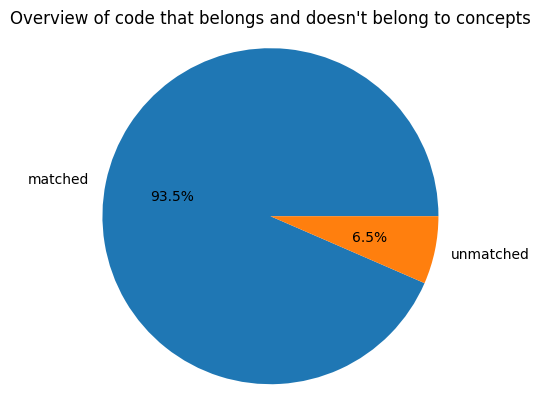

In [7]:
plt.pie(
    [len(matched_files), len(unmatched_files)],
    labels=["matched", "unmatched"],
    autopct='%1.1f%%'
)
plt.title("Overview of code that belongs and doesn't belong to concepts")
plt.axis('equal')  # keep the pie chart as a circle
plt.show()

## LLM Concept Assessment Prompt

In [10]:
def create_assessment_prompt(concept, source_code, file_path):
    """Create a prompt for LLM assessment of how well code implements a concept."""
    
    prompt = f"""
    
You are a software architecture expert. Please analyze the following source code and assess how well it implements the specified concept.

CONCEPT TO ASSESS:
Name: {concept['name']}
Description: {concept['description']}
Rationale: {concept['rationale']}

FILE PATH: {file_path}

SOURCE CODE:
{source_code}

Please provide a confidence score between 0.0 and 1.0 that indicates how certain you are that this source code implements the specified concept:
- 0.0 = Definitely does not implement this concept
- 0.5 = Uncertain / partially implements the concept
- 1.0 = Definitely implements this concept

Don't comment on design issues (e.g. lack of encapsulation, code structure quality, etc.) which are here irrelevant for the scoring.

Focus on:
- Whether the concept is meaningfully and recognizably implemented in the code
- Whether its *intent*, *mechanism*, or *role* aligns with the description

Respond with ONLY a single number between 0.1 and 1.0, followed by a brief explanation (max 100 words).

Format: SCORE: X.X\nEXPLANATION: [your explanation]

"""
    
    return prompt

### Helper Functions

In [11]:
def assess_concept_implementation(concept, source_code, file_path):
    """Use OpenAI API to assess how well code implements a concept."""
    prompt = create_assessment_prompt(concept, source_code, file_path)
    
    try:
        completion = client.chat.completions.create(
            model=MODEL,
            messages=[{
                "role": "user",
                "content": prompt
            }],
            temperature=0.1
        )

        response_text = completion.choices[0].message.content
        return parse_assessment_response(response_text)

    except Exception as e:
        print(f"Error calling OpenAI API: {e}")
        return 0.0, f"Error: {e}"


def parse_assessment_response(response_text):
    """Extract SCORE and EXPLANATION from LLM response."""
    lines = response_text.split('\n')
    score_line = next((line for line in lines if line.startswith('SCORE:')), '')
    explanation_line = next((line for line in lines if line.startswith('EXPLANATION:')), '')

    # Extract score
    score = 0.0
    if score_line:
        score_str = score_line.replace('SCORE:', '').strip()
        try:
            score = float(score_str)
        except ValueError:
            print(f"Could not parse score: {score_str}")

    # Extract explanation
    explanation = explanation_line.replace('EXPLANATION:', '').strip() if explanation_line else response_text

    return score, explanation


print("LLM assessment functions defined.")

LLM assessment functions defined.


## Main AI Assessment Function
So here we call the specified LLM for all files in a software system. Because we're also sending the source code of each file, this might get expensive and definitely takes long!

In [22]:
display_id = "live_output"

def analyze_all_concepts(concepts_data, base_path):
    """Analyze all concepts and their associated files, plus unmatched files."""

    display("Starting ...", display_id=display_id)
    
    # helper for reading source code
    def read_source_code(file_path):
        """Read source code from file."""
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                return file.read()
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            return ""

    # helper for creating an entry with default information
    def create_base_entry(file_path, concept_type, concept, score, explanation):
        source_code = read_source_code(file_path)
        return {
            'concept_type': concept_type,
            'concept_name': concept.get('name'),
            'concept_description': concept.get('description'),
            'file_path': file_path,
            'file_name': os.path.basename(file_path),
            'score': score,
            'explanation': explanation,
            'code_length': len(source_code)
        }
            
    results = []

    concept_types = concepts_data.keys()
    
    for concept_type in tqdm(concept_types, "Concept Types"):
        concept_type_name = concept_type.replace("_concepts", "")
        
        concepts = concepts_data.get(concept_type, [])
        
        for concept in tqdm(concepts[:2], f"Processing {concept_type_name} concepts"):
            concept_name = concept['name']
            files = matched_files_dict[concept_type][concept_name]
            
            for file_path in tqdm(files[:2], f"Processing files for {concept_name.lower()} concept "):
                source_code = read_source_code(file_path)
                if not source_code:
                    continue
                score, explanation = assess_concept_implementation(concept, source_code, file_path)
                
                entry = create_base_entry(
                    file_path,
                    concept_type_name,
                    concept,
                    score,
                    explanation
                )

                results.append(entry)
                update_display(f"Score for the {concept_type_name} concept {concept_name.lower()} for file {entry['file_name']}: {score}", display_id=display_id)

        # add dummy data for unmatched files
        for file_path in tqdm(unmatched_files, "Matched Files"):
            entry = create_base_entry(file_path, concept_type_name, {'name': None, 'description': None}, 0, "n/a")

    return pd.DataFrame(results)

# Run analysis
results_df = analyze_all_concepts(concepts_data, BASE_PATH)
# add an alternative path for later visualization by concepts and not by file paths
results_df['concept_path'] = results_df['concept_name'] + "/" + results_df['file_name']
results_df.head()

'Current output: business Comment, PostNotInPastException.java: 0.8'

Concept Types:   0%|          | 0/2 [00:00<?, ?it/s]

Processing technical concepts:   0%|          | 0/2 [00:00<?, ?it/s]

Processing files for concept Boundary:   0%|          | 0/2 [00:00<?, ?it/s]

Processing files for concept Interactor:   0%|          | 0/2 [00:00<?, ?it/s]

Matched Files:   0%|          | 0/21 [00:00<?, ?it/s]

Processing business concepts:   0%|          | 0/2 [00:00<?, ?it/s]

Processing files for concept Site:   0%|          | 0/2 [00:00<?, ?it/s]

Processing files for concept Comment:   0%|          | 0/2 [00:00<?, ?it/s]

Matched Files:   0%|          | 0/21 [00:00<?, ?it/s]

,concept_type,concept_name,concept_description,file_path,file_name,score,explanation,code_length
0,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,DownloadFileResponseModel.java,1.0,"The code defines `DownloadFileResponseModel`, ...",257
1,technical,Boundary,Defines the interfaces for communication betwe...,../../../dropover-at/backend/src/main/java/at/...,AddSchedulingDateRequestModel.java,1.0,The code defines `AddSchedulingDateRequestMode...,227
2,technical,Interactor,Contains the application-specific business log...,../../../dropover-at/backend/src/main/java/at/...,GetRangedComments.java,1.0,The `GetRangedComments` class is a textbook im...,1489
3,technical,Interactor,Contains the application-specific business log...,../../../dropover-at/backend/src/test/java/at/...,GetAllTodosTest.java,0.9,"The provided code is a test for an Interactor,...",2814
4,business,Site,A 'Site' represents a distinct container or co...,../../../dropover-at/backend/src/main/java/at/...,Site.java,0.9,The code defines a Java interface named `Site`...,428


#### Optional: Save results for later alternative visualizations etc.

In [23]:
output_filename = f'concept_analysis_results_{MODEL.replace("/","-")}_{PROJECT_NAME}.csv'
results_df.to_csv(output_filename, index=False)
print(f"Complete results (including unmatched files) exported to {output_filename}")

Complete results (including unmatched files) exported to concept_analysis_results_google-gemini-2.5-pro_dropover-at.csv


## Visualization

### Helper functions for treemap creation
(don't ask me how this works; it's vibe coded)

In [88]:
def normalize_path(path):
    """Normalize file path to remove leading base path prefix."""
    # Remove the common prefix to get relative paths
    if path.startswith(BASE_PATH):
        return path[len(BASE_PATH):]
    return path

def create_treemap_data(df_subset, path_col):
    """Build filesystem hierarchy treemap data."""
    # Normalize paths
    df_subset = df_subset.copy()
    df_subset['normalized_path'] = df_subset[path_col].apply(normalize_path)
    
    # Build directory structure
    directories = set()
    files_data = {}
    
    # Collect all directories and files
    for _, row in df_subset.iterrows():
        path = row['normalized_path']
        path_parts = path.split('/')
        
        # Add all parent directories
        for i in range(1, len(path_parts)):
            dir_path = '/'.join(path_parts[:i])
            if dir_path:
                directories.add(dir_path)
        
        # Store file data
        files_data[path] = row
    
    # Calculate directory sizes (sum of all files in directory and subdirectories)
    dir_sizes = defaultdict(int)
    dir_scores = defaultdict(list)
    dir_file_counts = defaultdict(int)
    
    for file_path, file_data in files_data.items():
        path_parts = file_path.split('/')
        
        # Add file size and score to all parent directories
        for i in range(1, len(path_parts)):
            dir_path = '/'.join(path_parts[:i])
            if dir_path:
                dir_sizes[dir_path] += file_data['code_length']
                dir_scores[dir_path].append(file_data['score'])
                dir_file_counts[dir_path] += 1
    
    # Build treemap data
    ids = []
    labels = []
    parents = []
    values = []
    colors = []
    customdata = []
    
    # Root node
    root_id = "root"
    ids.append(root_id)
    labels.append(f"Project {PROJECT_NAME}")
    parents.append("")
    values.append(df_subset['code_length'].sum())
    colors.append(df_subset['score'].mean())
    customdata.append(
        f"Total files: {len(df_subset)}<br>"
        f"Avg Score: {df_subset['score'].mean():.2f}<br>"
        f"Total Lines: {df_subset['code_length'].sum():,}"
    )
    
    # Add directories
    for dir_path in sorted(directories):
        path_parts = dir_path.split('/')
        dir_name = path_parts[-1]
        
        # Determine parent
        if len(path_parts) == 1:
            parent_id = root_id
        else:
            parent_path = '/'.join(path_parts[:-1])
            parent_id = parent_path
        
        dir_id = dir_path
        avg_score = np.mean(dir_scores[dir_path]) if dir_scores[dir_path] else 0.0
        
        ids.append(dir_id)
        labels.append(dir_name)
        parents.append(parent_id)
        values.append(dir_sizes[dir_path])
        colors.append(avg_score)
        customdata.append(
            f"Directory: {dir_path}<br>"
            f"Files: {dir_file_counts[dir_path]}<br>"
            f"Avg Score: {avg_score:.2f}<br>"
            f"Total Lines: {dir_sizes[dir_path]:,}"
        )
    
    # Add files
    for file_path, file_data in files_data.items():
        path_parts = file_path.split('/')
        file_name = path_parts[-1]
        
        # Determine parent directory
        if len(path_parts) == 1:
            parent_id = root_id
        else:
            parent_dir = '/'.join(path_parts[:-1])
            parent_id = parent_dir
        
        file_id = file_path
        
        # Handle unmatched files (concept_name is NaN)
        if pd.isna(file_data['concept_name']):
            concept_info = "No concept match"
            explanation = file_data['explanation']
        else:
            concept_info = f"Concept: {file_data['concept_name']}"
            explanation = file_data['explanation'][:100] + "..." if len(file_data['explanation']) > 100 else file_data['explanation']
        
        ids.append(file_id)
        labels.append(file_name)
        parents.append(parent_id)
        values.append(file_data['code_length'])
        colors.append(file_data['score'])
        customdata.append(
            f"File: {file_name}<br>"
            f"Score: {file_data['score']:.2f}<br>"
            f"Lines: {file_data['code_length']}<br>"
            f"{concept_info}<br>"
            f"Path: {file_data['file_path']}<br>"
            f"Explanation: {explanation}"
        )
    
    return {
        'ids': ids,
        'labels': labels,
        'parents': parents,
        'values': values,
        'colors': colors,
        'customdata': customdata
    }

In [97]:
def create_treemap_visualization(treemap_data, title, colorscale):
    """Create a Plotly treemap for the given hierarchy."""
    
    fig = go.Figure(go.Treemap(
        ids=treemap_data['ids'],
        labels=treemap_data['labels'],
        parents=treemap_data['parents'],
        values=treemap_data['values'],
        customdata=treemap_data['customdata'],
        hovertemplate='<b>%{label}</b><br>%{customdata}<extra></extra>',
        marker=dict(
            colors=treemap_data['colors'],
            colorscale=colorscale,
            cmin=0,
            cmax=1
        ),
        textinfo="label+value",
        textposition="middle center",
        textfont=dict(size=8),
        branchvalues="total"
    ))
    
    fig.update_layout(
        title={
            'text': title,
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        margin=dict(t=10, l=10, r=10, b=10),
        width=1920/2,
        height=1080/2
    )
    
    return fig

print("Helper functions defined.")

Helper functions defined.


### Create file structure based views

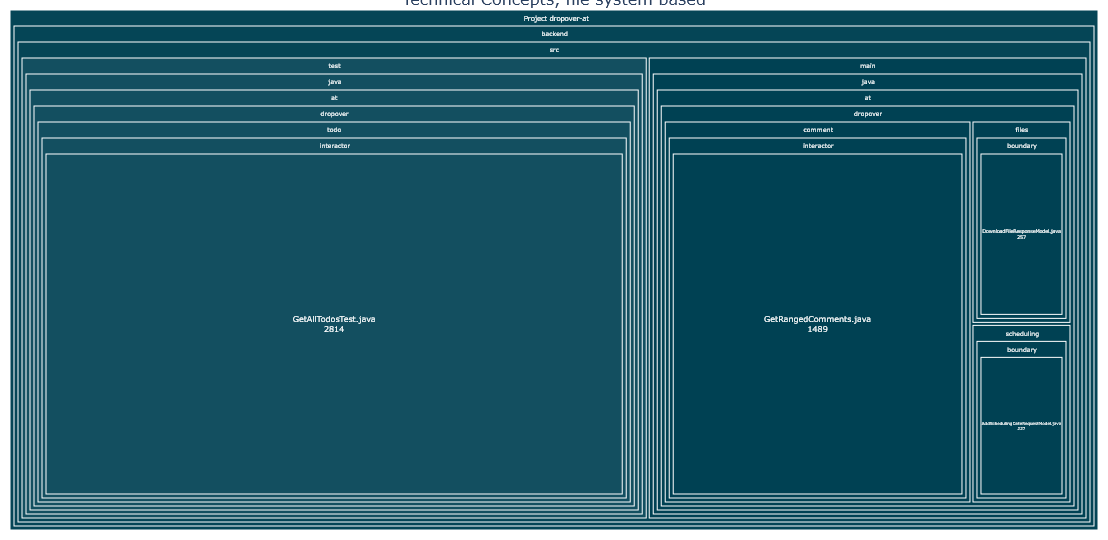

In [99]:
# Create treemap for technical files based on filesystem structure
technical_df = results_df[results_df['concept_type'] == 'technical']
technical_treemap_data = create_treemap_data(technical_df, 'file_path')

technical_colorscale = [
    (0.0, '#ffffff'),   # White for score 0
    (0.01, '#bfcfd4'),   # Almost white for score >0
    (1.0, '#004153')    # Black for score 1
]

technical_fig = create_treemap_visualization(
    technical_treemap_data, 
    'Technical Concepts, file system based',
    technical_colorscale
)

technical_fig.show()

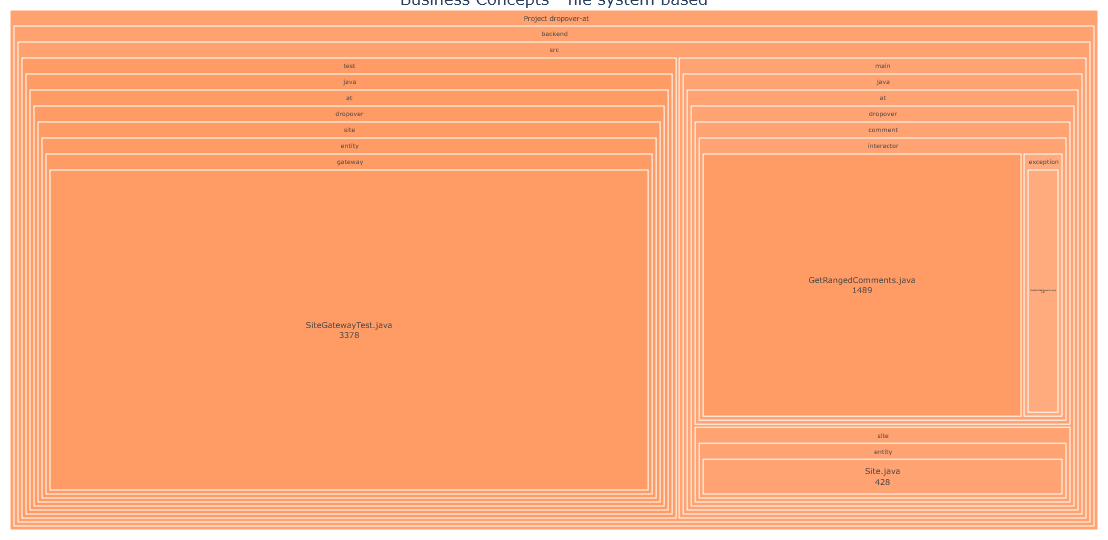

In [100]:
# Create treemap for business files based on filesystem structure
business_df = results_df[results_df['concept_type'] == 'business']
business_treemap_data = create_treemap_data(business_df, 'file_path')

business_colorscale = [
    (0.0, '#ffffff'),   # White for score 0
    (0.01, '#ffe6d9'),   # Almost white for score >0
    (1.0, '#ff9c66')    # Black for score 1
]

business_fig = create_treemap_visualization(
    business_treemap_data, 
    'Business Concepts - file system based',
    business_colorscale
)

business_fig.show()

### Create concepts based views

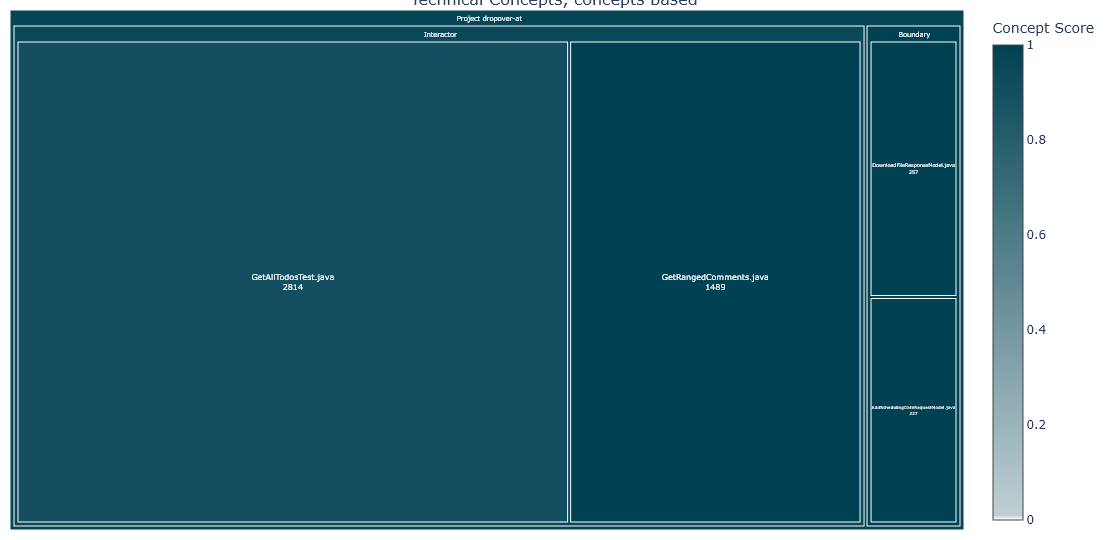

In [95]:
technical_treemap_data = create_treemap_data(technical_df, 'concept_path')

technical_fig = create_treemap_visualization(
    technical_treemap_data, 
    'Technical Concepts, concepts based',
    technical_colorscale
)

technical_fig.show()

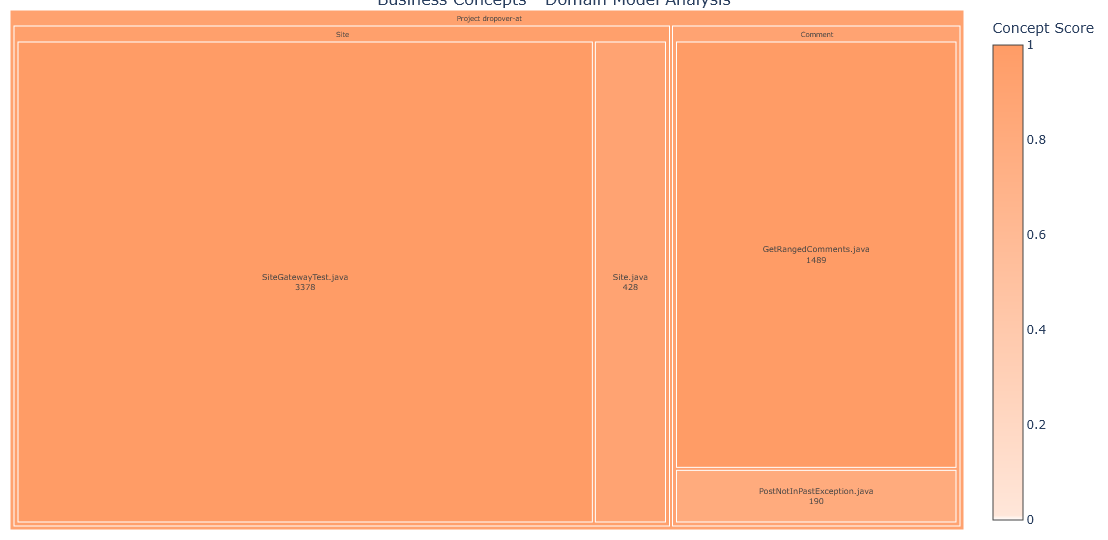

In [96]:
business_treemap_data = create_treemap_data(business_df, 'concept_path')

business_colorscale = [
    (0.0, '#ffffff'),   # White for score 0
    (0.01, '#ffe6d9'),   # Almost white for score >0
    (1.0, '#ff9c66')    # Black for score 1
]


business_fig = create_treemap_visualization(
    business_treemap_data, 
    'Business Concepts - Domain Model Analysis',
    business_colorscale
)

business_fig.show()

## Advanced statistics
LLM wanted so say something about additional stuff. So here it is!

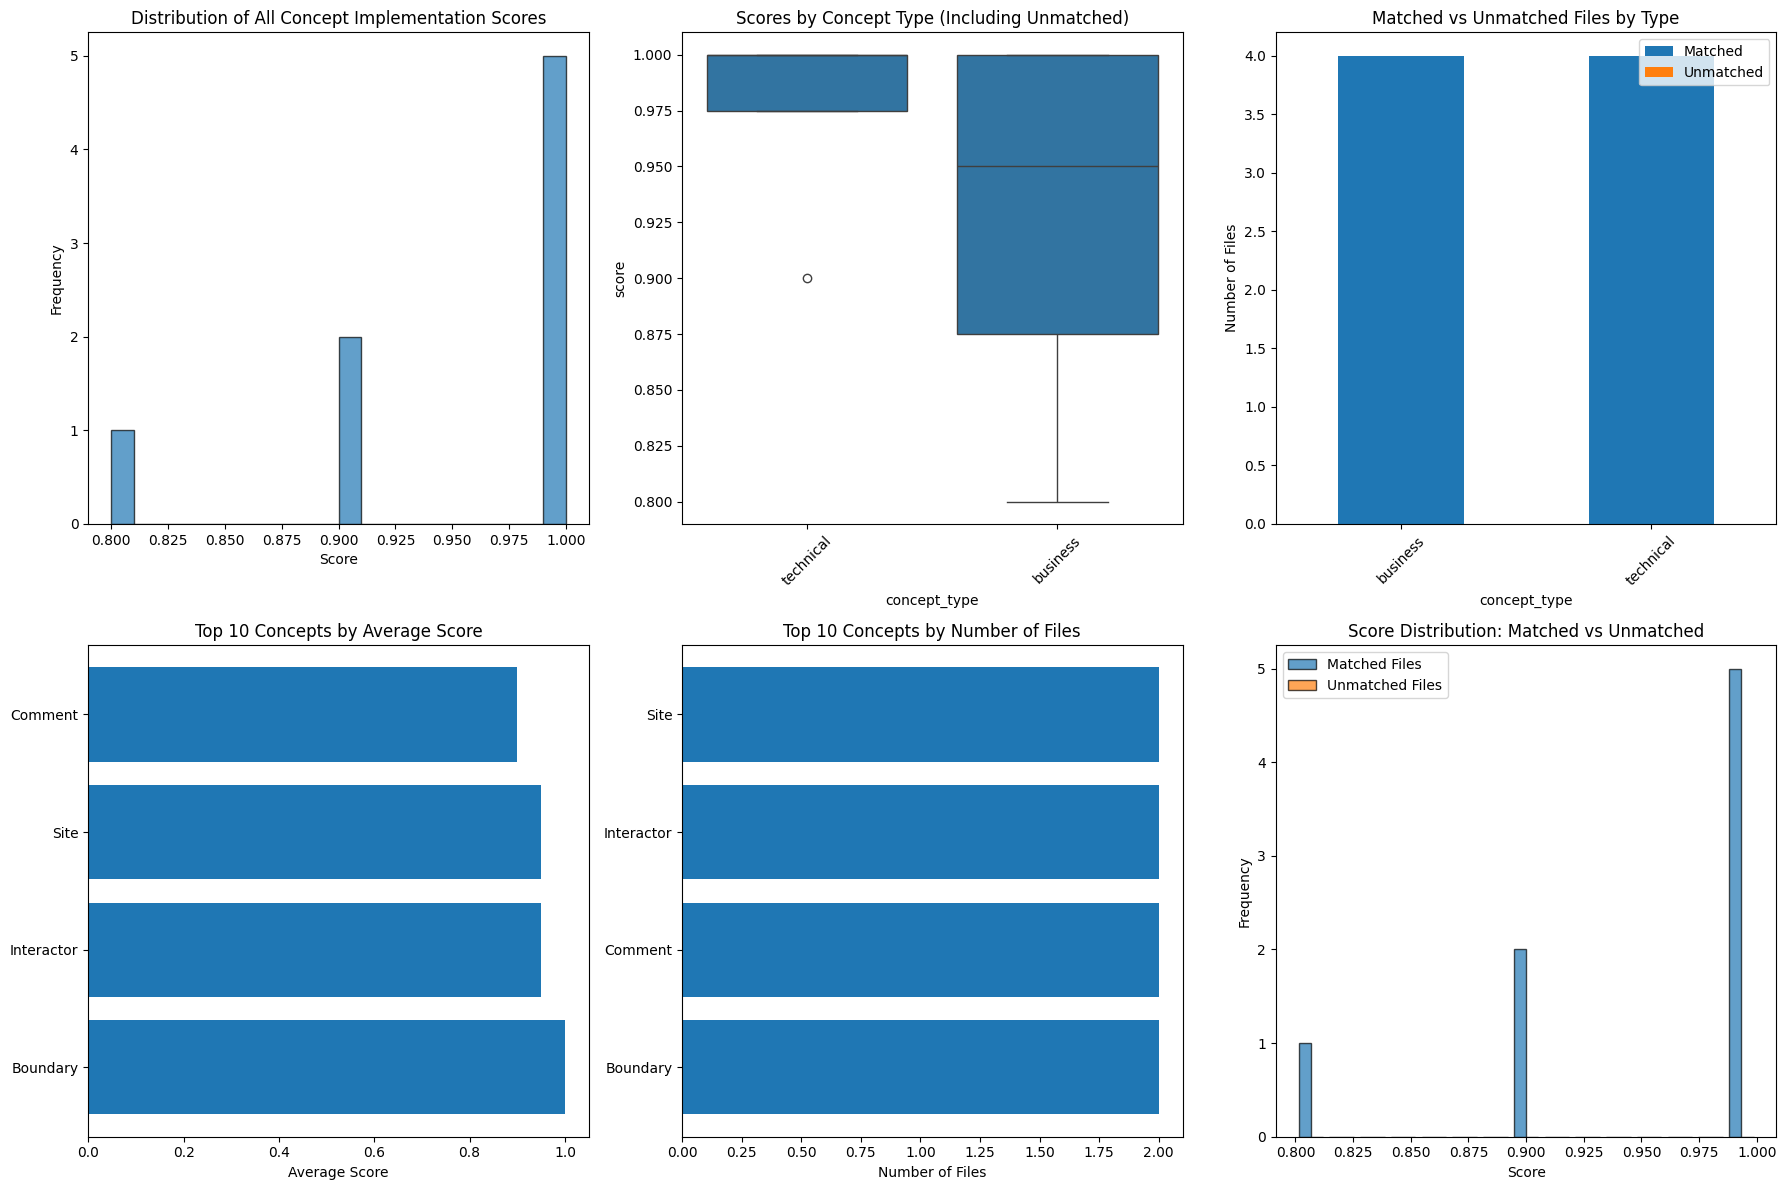

In [104]:
# Enhanced visualizations including unmatched files
if not results_df.empty:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Score distribution
    axes[0, 0].hist(results_df['score'], bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Distribution of All Concept Implementation Scores')
    axes[0, 0].set_xlabel('Score')
    axes[0, 0].set_ylabel('Frequency')
    
    # Scores by concept type
    sns.boxplot(data=results_df, x='concept_type', y='score', ax=axes[0, 1])
    axes[0, 1].set_title('Scores by Concept Type (Including Unmatched)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Matched vs Unmatched distribution
    matched_counts = results_df.groupby('concept_type').agg({
        'concept_name': lambda x: [x.notna().sum(), x.isna().sum()]
    })['concept_name'].apply(pd.Series)
    matched_counts.columns = ['Matched', 'Unmatched']
    matched_counts.plot(kind='bar', ax=axes[0, 2], stacked=True)
    axes[0, 2].set_title('Matched vs Unmatched Files by Type')
    axes[0, 2].set_ylabel('Number of Files')
    axes[0, 2].tick_params(axis='x', rotation=45)
    
    # Top concepts by average score (excluding unmatched)
    matched_df = results_df[results_df['concept_name'].notna()]
    if not matched_df.empty:
        concept_scores = matched_df.groupby('concept_name')['score'].mean().sort_values(ascending=False).head(10)
        axes[1, 0].barh(concept_scores.index, concept_scores.values)
        axes[1, 0].set_title('Top 10 Concepts by Average Score')
        axes[1, 0].set_xlabel('Average Score')
    
    # Files per concept (excluding unmatched)
    if not matched_df.empty:
        files_per_concept = matched_df.groupby('concept_name').size().sort_values(ascending=False).head(10)
        axes[1, 1].barh(files_per_concept.index, files_per_concept.values)
        axes[1, 1].set_title('Top 10 Concepts by Number of Files')
        axes[1, 1].set_xlabel('Number of Files')
    
    # Score distribution: Matched vs Unmatched
    matched_scores = results_df[results_df['concept_name'].notna()]['score']
    unmatched_scores = results_df[results_df['concept_name'].isna()]['score']
    
    axes[1, 2].hist([matched_scores, unmatched_scores], bins=15, 
                   label=['Matched Files', 'Unmatched Files'], 
                   alpha=0.7, edgecolor='black')
    axes[1, 2].set_title('Score Distribution: Matched vs Unmatched')
    axes[1, 2].set_xlabel('Score')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()